In [73]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt
from utils import parse_casenum
from llm import get_embeddings

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

N_CLUSTERS = 3


In [74]:
dfa = dt.get_agenda_items(verbose=False)

In [75]:
# Get the agenda item embeddings
texts = dfa['project_summary'].tolist()
embeddings = get_embeddings(texts)

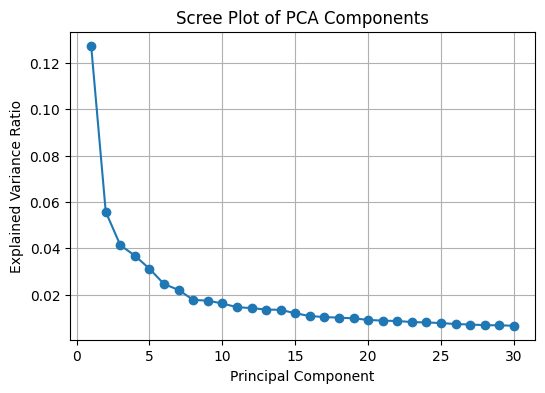

In [76]:
# PCA scree plot
pca = PCA()
pca.fit(embeddings)
explained_variance = pca.explained_variance_ratio_[0:30]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Scree Plot of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()


In [77]:
# Reduce embeddings to 10 dimensions
pca = PCA(n_components=10)
embeddings_reduced = pca.fit_transform(embeddings)

In [78]:
# Cluster into 3 clusters using kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(embeddings_reduced)
dfa['cluster'] = kmeans.labels_
dfa['cluster'].value_counts()

cluster
0    543
1    118
2     69
Name: count, dtype: int64

In [79]:
# Show random examples from each cluster
for cluster in dfa['cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_items = dfa[dfa['cluster'] == cluster]
    sample_items = cluster_items.sample(3)
    for idx, row in sample_items.iterrows():
        print("---")
        print(row['project_summary'])
    print("======")

Cluster 0:
---
The proposed project involves the demolition of 340,339 square feet of existing office buildings and the construction of a Master Planned, Multiple-Phased, Mixed Use development. The development will include up to 2,634,268 square feet of combined residential and non-residential floor area on a 1,062,923 square foot lot. At the conclusion of Phase 8, the project will consist of 10 buildings on eight new lots, featuring 1,119,257 square feet of residential floor area, up to 1,009 dwelling units including 68 Work-Live units, and 1,515,011 square feet of non-residential floor area. The project will also include 228 hotel rooms, a new private street, and 231,445 square feet of publicly accessible open space. The development will provide a maximum of 5,548 vehicle parking spaces, 870 long-term bicycle parking spaces, and 264 short-term bicycle parking spaces.
---
The proposed project involves the demolition of two existing connected surface parking lots to construct two new r

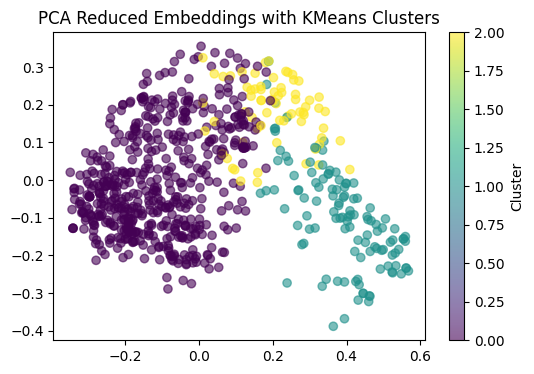

In [80]:
# Scatter plot colored by cluster
plt.figure(figsize=(6, 4))
plt.scatter(
    embeddings_reduced[:, 0], 
    embeddings_reduced[:, 1], 
    c = kmeans.labels_,
    alpha=0.6
)
plt.title('PCA Reduced Embeddings with KMeans Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [81]:
df_new = dfa[['date', 'item_no', 'title', 'project_summary', 'cluster']].copy()
new_cols = [f'd{k}' for k in range(embeddings_reduced.shape[1])]
df_new = pd.concat([df_new, pd.DataFrame(embeddings_reduced, columns=new_cols)], axis=1)
df_new.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'agenda_item_with_embeddings.csv'),
    index=False,
    header=True
)

In [82]:
# create a dataframe with the cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=new_cols)
centroids['cluster'] = range(N_CLUSTERS)
centroids = centroids[['cluster'] + [col for col in centroids.columns if col != 'cluster']]
centroids.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'cluster_centroids.csv'),
    index=False,
    header=True
)